# Resnet50 for Blades High Resolution

In [1]:
from theano.sandbox import cuda

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


In [2]:
%matplotlib inline
import utils3
#reload(utils3)
from utils3 import *
from __future__ import division, print_function

Using Theano backend.


In [5]:
path = "/home/ubuntu/fast-ai/data/blade_ho/"
model_path = '/home/ubuntu/fast-ai/data/blade_ho/models/'
batch_size=64
os.path.exists(model_path)

True

In [6]:
import resnet50; reload(resnet50)
from resnet50 import Resnet50

In [7]:
resnet_model = Resnet50(include_top=False).model

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [8]:
resnet_model.output_shape

(None, 2048, 7, 7)

In [9]:
batches = get_batches(path+'train', shuffle=False, batch_size=batch_size)
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size*2)

Found 1137 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [10]:
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames, test_filenames) = get_classes(path)

Found 1137 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 23 images belonging to 1 classes.


In [11]:
trn_features = resnet_model.predict_generator(batches, batches.nb_sample)

In [12]:
val_features = resnet_model.predict_generator(val_batches, val_batches.nb_sample)

In [13]:
save_array(model_path + 'train_resnet50_features.bc', trn_features)
save_array(model_path + 'valid_resnet50_features.bc', val_features)

In [10]:
trn_features = load_array(model_path+'train_resnet50_features.bc')
val_features = load_array(model_path+'valid_resnet50_features.bc')

In [14]:
trn_features.shape

(1137, 2048, 7, 7)

## Global Average Pooling

In [19]:
def get_ap_layers(p):
    return [
        GlobalAveragePooling2D(input_shape=resnet_model.output_shape[1:]),
        Dropout(p),
        Dense(3, activation='softmax')
    ]

In [20]:
model = Sequential(get_ap_layers(.2))

In [21]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.fit(trn_features, trn_labels, nb_epoch=4, batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 1137 samples, validate on 150 samples
Epoch 1/4
1137/1137 [==============================] - 0s - loss: 0.7984 - acc: 0.6280 - val_loss: 0.9879 - val_acc: 0.5400
Epoch 2/4
1137/1137 [==============================] - 0s - loss: 0.7863 - acc: 0.6332 - val_loss: 0.9499 - val_acc: 0.5533

In [26]:
model.optimizer.lr=1e-5

In [19]:
model.save_weights(path+'models/resnet.h5')

In [ ]:
model.load_weights(path+'models/resnet.h5')

In [20]:
model.evaluate(val_features, val_labels)

 32/100 [========>.....................] - ETA: 0s

[0.33116345405578612, 0.85999999999999999]

## Running on Test Set and Saving Results

In [21]:
import csv
test_batches = get_batches(path + 'test', shuffle=False)
test_features = resnet_model.predict_generator(test_batches, test_batches.nb_sample)
predicts = model.predict(test_features, batch_size=4)
predicts = [x[1] for x in predicts]
predicts = np.clip(predicts, 0.02, 0.98)
np.savetxt(path + 'results/' + 'predicts.csv', predicts, delimiter=',' , fmt='%1.5f')

Found 100 images belonging to 1 classes.


In [24]:
test_batches = get_batches(path + 'test', shuffle=False)
wtr = csv.writer(open (path + 'results/' + 'filenames.csv', 'w'), delimiter=',', lineterminator='\n')
for x in test_batches.filenames : wtr.writerow ([x])

Found 100 images belonging to 1 classes.


In [25]:
%%bash -s "$path"
cd $1/results/
~/fast-ai/scripts/clean_data.sh filenames.csv predicts.csv

0AD0E0A5-3683-4BE7-B0EF-A43046B86900.jpg,0.02951
0BE5C2EA-03E0-45D5-A45F-508AA000B19E.jpg,0.09086
0C09E172-0808-4A33-A53C-69D973E64464.jpg,0.04486
0E389832-F4AB-4EC2-95E3-24FE4762EB05.jpg,0.14438
0EE2C8FD-F80F-4C02-96F3-8A2CAA0668EE.jpg,0.96697
1B191037-82EB-4E41-90F3-8F32AAF61834.jpg,0.69049
1DF3F5C8-2482-457A-98C2-FEE0012EBD2B.jpg,0.02598
1E098C48-23BE-43BF-8EB8-B9B96623178B.jpg,0.85461
1E35C282-A773-484B-B879-447F3BAC9841.jpg,0.07309
1EA984B8-5A4C-4FC0-8811-4D7ABC49A3FA.jpg,0.23329


In [25]:
%%bash -s "$path"
cd $1/results/
awk -F ',' '{if ($2 < 0.5) print $1 ";erosion"; else print $1 ";surface_voids";}' submission.csv | sort > resnet_results_categories.txt
head resnet_results_categories.txt

002C3A76-6C93-4B03-BD40-DD9AFFB3ED9F;surface_voids
01387596-3ECF-478E-9A4D-1496579F417C;erosion
034F7678-9095-44EF-8905-FA31B1D34865;surface_voids
042E1ADD-5E48-4512-BF07-AE32F9326045;erosion
047F012D-9936-46BD-A170-29BD118AE529;surface_voids
06DFF54C-66FB-4E90-AF76-540BFAB1583B;surface_voids
06F4D1DB-0479-41D2-A1C8-5935D71D2A4A;surface_voids
0AD0E0A5-3683-4BE7-B0EF-A43046B86900;erosion
0BE5C2EA-03E0-45D5-A45F-508AA000B19E;erosion
0C09E172-0808-4A33-A53C-69D973E64464;erosion


In [26]:
%%bash -s "$path"
cd $1/results/
join -t ";" resnet_results_categories.txt test_images_defects.txt | sort -u -t";" -k1,1 | awk -F ';' '$2 == $3' | wc -l

83


In [27]:
def my_predict(imgs, resnet_model, addon_model):
    resnet_preds = resnet_model.predict(imgs)
    all_preds = addon_model.predict(resnet_preds)
    idxs = np.argmax(all_preds, axis=1)
    preds = [all_preds[i, idxs[i]] for i in range(len(idxs))]
    return np.array(preds), idxs

In [28]:
batches = get_batches(path+'test/', batch_size=4)

Found 100 images belonging to 1 classes.


array([ 0.9326,  0.5189,  0.9252,  0.8627], dtype=float32)

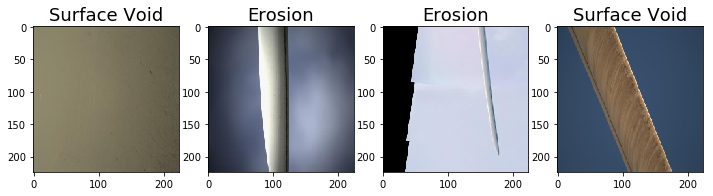

In [29]:
imgs,labels = next(batches)
preds, idxs = my_predict(imgs, resnet_model, model)
titles = map(lambda idx: ["Erosion", "Surface Void"][idx], idxs)
plots(imgs, titles=titles)
preds

## Resnet Large

In [5]:
resnet_model = Resnet50(include_top=False, size=(400,400)).model

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 400, 400)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [6]:
resnet_model.output_shape

(None, 2048, 13, 13)

In [7]:
batches = get_batches(path+'train', shuffle=False, batch_size=batch_size, target_size=(400,400))
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size*2, target_size=(400,400))
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames, test_filenames) = get_classes(path)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [8]:
trn_features = resnet_model.predict_generator(batches, batches.nb_sample)

In [9]:
val_features = resnet_model.predict_generator(val_batches, val_batches.nb_sample)

In [61]:
save_array(model_path + 'train_resnet50_lrg_features.bc', trn_features)
save_array(model_path + 'valid_resnet50_lrg_features.bc', val_features)

In [8]:
trn_features = load_array(model_path+'train_resnet50_lrg_features.bc')
val_features = load_array(model_path+'valid_resnet50_lrg_features.bc')

In [10]:
trn_features.shape

(23000, 2048, 13, 13)

In [13]:
model = Sequential(get_ap_layers(.01))

In [14]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.fit(trn_features, trn_labels, nb_epoch=3, batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 20s - loss: 0.0604 - acc: 0.9817 - val_loss: 0.0247 - val_acc: 0.9935

In [ ]:
import csv
test_batches = get_batches(path+'test', shuffle=False, batch_size=1, target_size=(400,400))
test_features = resnet_model.predict_generator(test_batches, batches.nb_sample)
#save_array(model_path + 'test_resnet50_lrg_features.bc', test_features)
wtr = csv.writer(open (path + 'results/' + 'filenames.csv', 'w'), delimiter=',', lineterminator='\n')
for x in test_batches.filenames : wtr.writerow ([x])
    
predicts = model.predict(test_features, batch_size=1)
predicts = [x[1] for x in predicts]
predicts = np.clip(predicts, 0.02, 0.98)
np.savetxt(path + 'results/' + 'predicts.csv', predicts, delimiter=',' , fmt='%1.5f')

In [ ]:
test_features = load_array(model_path+'test_resnet50_lrg_features.bc')